In [16]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras import layers
from keras.utils import img_to_array
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image

In [17]:
colored_images_path = "./landscapes/archive/"
gray_images_path = "./landscapes/gray_archive/"

colored_images = glob.glob("./landscapes/archive/*.jpg")

In [10]:
i = 0
for image in colored_images:
    if not image.endswith(('.jpg')):
        continue
    os.rename(image, f"./landscapes/archive/c_{i}.jpg")
    i += 1

In [18]:
colored_images

['./landscapes/archive/c_1131.jpg',
 './landscapes/archive/c_4049.jpg',
 './landscapes/archive/c_3726.jpg',
 './landscapes/archive/c_2438.jpg',
 './landscapes/archive/c_3040.jpg',
 './landscapes/archive/c_1657.jpg',
 './landscapes/archive/c_1643.jpg',
 './landscapes/archive/c_3054.jpg',
 './landscapes/archive/c_3732.jpg',
 './landscapes/archive/c_259.jpg',
 './landscapes/archive/c_1125.jpg',
 './landscapes/archive/c_4075.jpg',
 './landscapes/archive/c_271.jpg',
 './landscapes/archive/c_2404.jpg',
 './landscapes/archive/c_517.jpg',
 './landscapes/archive/c_2362.jpg',
 './landscapes/archive/c_503.jpg',
 './landscapes/archive/c_2376.jpg',
 './landscapes/archive/c_3068.jpg',
 './landscapes/archive/c_1119.jpg',
 './landscapes/archive/c_4061.jpg',
 './landscapes/archive/c_265.jpg',
 './landscapes/archive/c_2410.jpg',
 './landscapes/archive/c_1694.jpg',
 './landscapes/archive/c_3083.jpg',
 './landscapes/archive/c_3097.jpg',
 './landscapes/archive/c_2389.jpg',
 './landscapes/archive/c_1680.jpg

In [19]:
def sorting_data(data):
    text_to_convert = lambda text: int(text) if text.isdigit() else text
    int_key = lambda key: [text_to_convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=int_key)

files = os.listdir(colored_images_path)
files = sorting_data(files)

In [14]:
i = 0
for image in files:
    image = colored_images_path + image
    if not image.endswith(('.jpg')):
        continue
    img = Image.open(image)
    img_Gray = img.convert('L')
    img_Gray.save(f'./landscapes/gray_archive/gr_{i}.jpg')
    i += 1

In [20]:
SIZE = 160

In [21]:
color_img = []
files = os.listdir(colored_images_path)
files = sorting_data(files)
for i in tqdm(files):
    if not i.endswith(('.jpg')):
        continue
    else:
        img = cv2.imread(colored_images_path + '/' + i, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
files = os.listdir(gray_images_path)
files = sorting_data(files)
for i in tqdm(files):
    if not i.endswith(('.jpg')):
        continue
    else:
        img = cv2.imread(gray_images_path + '/' + i, 1)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

100%|██████████| 4319/4319 [00:10<00:00, 409.57it/s]


In [22]:
train_gray_images = gray_img[:3600]
train_colored_images = color_img[:3600]

test_gray_images = gray_img[3600:]
test_colored_images = color_img[3600:]

In [23]:
len(test_colored_images)

719

In [24]:
train_g = np.reshape(train_gray_images, (3600, SIZE, SIZE, 3))
train_c = np.reshape(train_colored_images, (3600, SIZE, SIZE, 3))
print('Shape of train colored images:',train_c.shape)


test_gray_image = np.reshape(test_gray_images, (719, SIZE, SIZE, 3))
test_color_image = np.reshape(test_colored_images, (719, SIZE, SIZE, 3))
print('Shape of test colored images',test_color_image.shape)

Shape of train colored images: (3600, 160, 160, 3)
Shape of test colored images (719, 160, 160, 3)


In [25]:
def down(filters, k_size, batch_normalization=True):
    downsampling = tf.keras.models.Sequential()
    downsampling.add(layers.Conv2D(filters, k_size, padding='same', strides=2))
    if batch_normalization:
        downsampling.add(layers.BatchNormalization())
    downsampling.add(keras.layers.LeakyReLU())
    return downsampling


def up(filters, k_size):
    upsampling = tf.keras.models.Sequential()
    upsampling.add(layers.Conv2DTranspose(filters, k_size, padding='same', strides=2))
    upsampling.add(keras.layers.LeakyReLU())
    return upsampling


In [26]:
def model():
    input = layers.Input(shape=[SIZE, SIZE, 3])
    d1 = down(128, (3, 3), False)(input)
    d2 = down(128, (3, 3), False)(d1)
    d3 = down(256, (3, 3), True)(d2)
    d4 = down(512, (3, 3), True)(d3)
    d5 = down(512, (3, 3), True)(d4)

    u1 = up(512, (3, 3))(d5)
    u1 = layers.concatenate([u1, d4])
    u2 = up(256, (3, 3))(u1)
    u2 = layers.concatenate([u2, d3])
    u3 = up(128, (3, 3))(u2)
    u3 = layers.concatenate([u3, d2])
    u4 = up(128, (3, 3))(u3)
    u4 = layers.concatenate([u4, d1])
    u5 = up(3, (3, 3))(u4)
    u5 = layers.concatenate([u5, input])

    output = layers.Conv2D(3, (2, 2), strides=1, padding='same')(u5)
    return tf.keras.Model(inputs=input, outputs=output)

model = model()

In [27]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
model.fit(train_g, train_c, epochs = 60, batch_size = 50)

Epoch 1/60


2023-03-11 10:28:33.235386: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


72/72 [==============================] - 155s 2s/step - loss: 0.2142 - accuracy: 0.3033
Epoch 2/60
72/72 [==============================] - 160s 2s/step - loss: 0.0903 - accuracy: 0.4212
Epoch 3/60
72/72 [==============================] - 156s 2s/step - loss: 0.0815 - accuracy: 0.4463
Epoch 4/60
72/72 [==============================] - 156s 2s/step - loss: 0.0745 - accuracy: 0.4653
Epoch 5/60
72/72 [==============================] - 127s 2s/step - loss: 0.0699 - accuracy: 0.4768
Epoch 6/60
72/72 [==============================] - 125s 2s/step - loss: 0.0667 - accuracy: 0.4852
Epoch 7/60
72/72 [==============================] - 164s 2s/step - loss: 0.0649 - accuracy: 0.4900
Epoch 8/60
72/72 [==============================] - 169s 2s/step - loss: 0.0622 - accuracy: 0.5011
Epoch 9/60
72/72 [==============================] - 160s 2s/step - loss: 0.0613 - accuracy: 0.5002
Epoch 10/60
72/72 [==============================] - 163s 2s/step - loss: 0.0606 - accuracy: 0.5110
Epoch 11/60
72/72 [=

In [28]:
model.evaluate(test_gray_image, test_color_image)

23/23 [==============================] - 12s 491ms/step - loss: 0.0574 - accuracy: 0.5276


[0.05742812529206276, 0.527640700340271]

In [32]:
model.save('gr_col_model')
model_loaded = keras.models.load_model('gr_col_model')

INFO:tensorflow:Assets written to: gr_col_model/assets


INFO:tensorflow:Assets written to: gr_col_model/assets


In [35]:
def show_images(colored, gray, pred):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Colored Image')
    plt.imshow(colored)
    plt.subplot(1, 3, 2)
    plt.title('Gray Image')
    plt.imshow(gray)
    plt.subplot(1, 3, 3)
    plt.title('Predicted Image')
    plt.imshow(pred)
    plt.show()


1/1 [==============================] - 0s 54ms/step


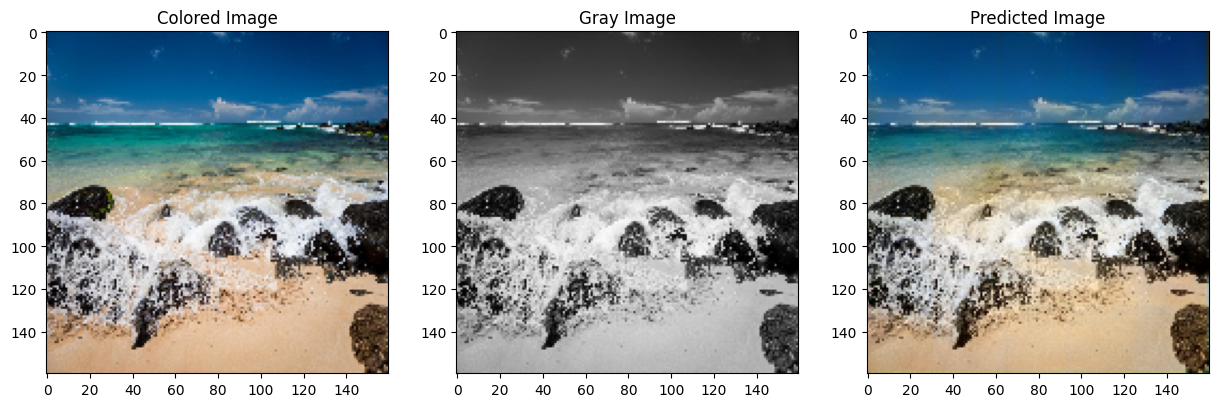

1/1 [==============================] - 0s 28ms/step


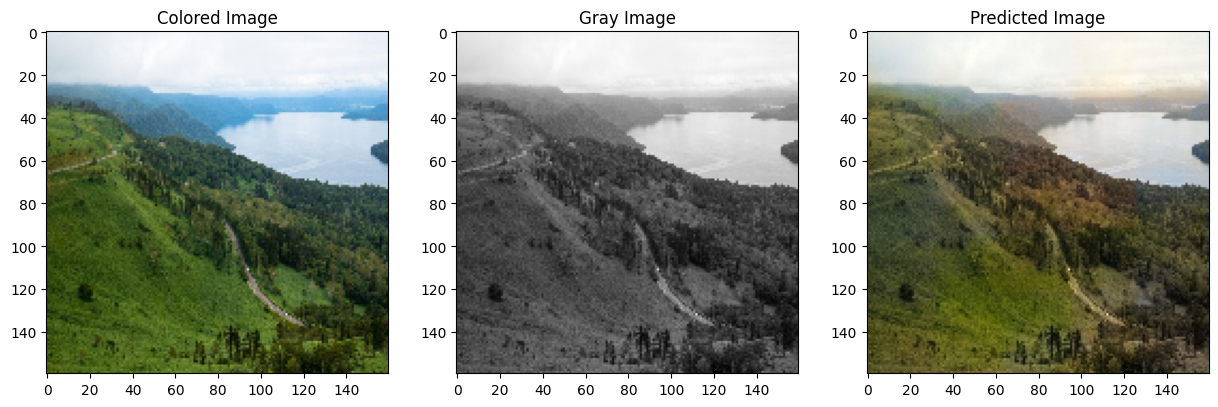

1/1 [==============================] - 0s 37ms/step


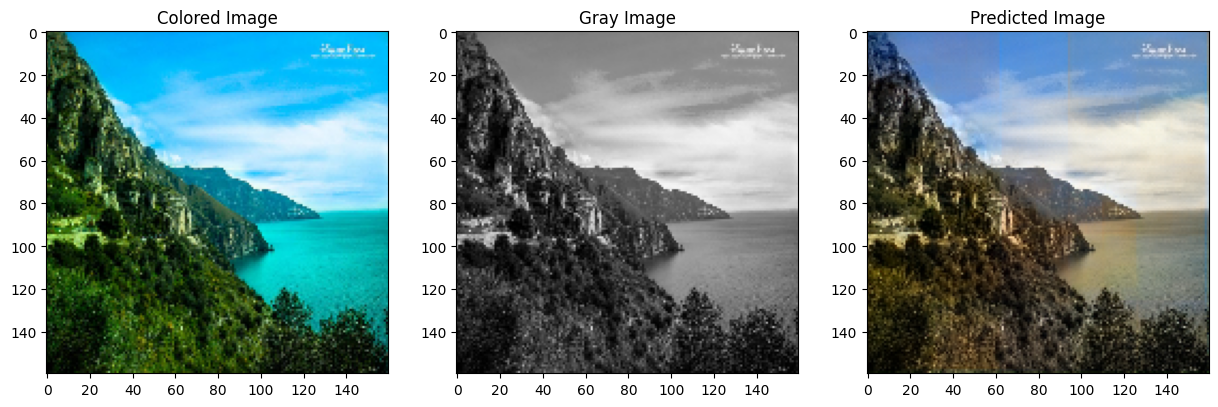

1/1 [==============================] - 0s 28ms/step


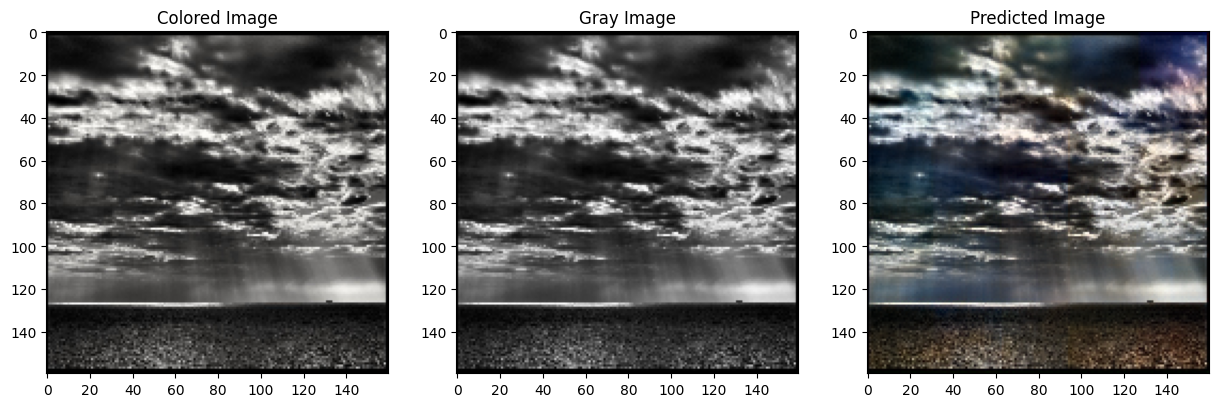

In [40]:
from PIL import Image

for i in range(21, 25):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1, SIZE, SIZE, 3)), 0.0, 1.0).reshape(SIZE, SIZE, 3)
    im = Image.fromarray((predicted * 255).astype(np.uint8))
    im.save(f"./preds/{i}.png")
    show_images(test_color_image[i], test_gray_image[i], predicted)